# Fine tuning SOTA model (RoBERTa) from Hugging Face for Document Classification

In this project, we will try to apply the transfer learning technique for NLP task. We will fine tune [BERT](https://arxiv.org/abs/1810.04805) and [RoBERTa](https://arxiv.org/abs/1907.11692) to do text/document classification. Most of the content are taken from [post1](https://curiousily.com/posts/sentiment-analysis-with-bert-and-hugging-face-using-pytorch-and-python/) and [post2](https://medium.com/@armandj.olivares/using-bert-for-classifying-documents-with-long-texts-5c3e7b04573d). In addition, we attempt to make it as general as possible that it can be used for any similar models (thanks to the Transformers library from [hugging face](https://huggingface.co/)) with any dataset by doing just some miner changes. 

In addition, we tried to overcome the limitation of the 512-sequence length of BERT and RoBERTa by using [Longformer](https://arxiv.org/abs/2004.05150) and [RoBERT](https://arxiv.org/abs/1910.10781). It stands for Recurrence over BERT where each ocument is segmented into smaller text and feed each of them to BERT. Then we extract the representation of each text chunk from (pooled_output) and feed the combined representation of each document to LSTM to classify long documents. We will see if this improve the results or overfit the data. We mainly used **python, Transformers, Pytorch, Sklearn**

## Result Summary

- Accuracy =  100%
- MCC = 100%


## Setup


In [1]:
# !pip install -qq -r requirements.txt

In [2]:
# !pip install -qq transformers

In [3]:
# watermark: "An IPython magic extension for printing date and time stamps, version numbers, and hardware information."

# %reload_ext watermark
# %watermark

In [4]:
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,transformers,seaborn,nltk,sklearn,tensorflow

Python implementation: CPython
Python version       : 3.8.3
IPython version      : 7.16.1

numpy       : 1.18.5
pandas      : 1.0.5
torch       : 1.7.0
transformers: 3.5.1
seaborn     : 0.10.1
nltk        : 3.5
sklearn     : 0.0
tensorflow  : 2.3.1



In [5]:
import transformers
import torch

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from datetime import datetime

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)
rcParams['figure.figsize'] = 10, 6

## Config

We configured this project so we can evaluate different pretrained models with minor changes. All our hyper-parameters are in this section. If you want to use another dataset, check the preprocessing section.

In [6]:
MAX_LEN = 512
BATCH_SIZE = 8
EPOCHS = 4
LEARNING_RATE = 2e-5

"""BERT Model and Tokenizer"""
# PRE_TRAINED_MODEL = 'bert-base_cased'
# TOKENIZER = transformers.BertTokenizer.from_pretrained(PRE_TRAINED_MODEL)
# PT_MODEL = transformers.BertModel.from_pretrained(PRE_TRAINED_MODEL)

"""RoBERTa Model and Tokenizer"""
PRE_TRAINED_MODEL = 'roberta-base'
TOKENIZER = transformers.RobertaTokenizer.from_pretrained(PRE_TRAINED_MODEL)
PT_MODEL = transformers.RobertaModel.from_pretrained(PRE_TRAINED_MODEL)

"""Longformer Model and Tokenizer"""
# PRE_TRAINED_MODEL = 'allenai/longformer-base-4096'
# PT_MODEL = transformers.LongformerModel.from_pretrained(PRE_TRAINED_MODEL)
# TOKENIZER = transformers.LongformerTokenizer.from_pretrained(PRE_TRAINED_MODEL)

model_path = '../models/' + PRE_TRAINED_MODEL + '_' + str(MAX_LEN) + '_best_model.bin'

'Longformer Model and Tokenizer'

In [7]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

## Data Preprocessing



If you use a deferent dataset and reading it as a panda's dataframe, just change the column header that accommodate the content to 'text' and the target column to 'label. Code is provided below.

In [8]:
df = pd.read_csv('../inputs/news_data_groomed.csv')
df.head()

,Unnamed: 0,title,text,label
0,8308,"Italy Plucks 2,000 Migrants from the Mediterra...",ROME (AP) — Italian rescue ships have pluck...,REAL
1,2765,The most unqualified media personalities on TV...,"Monday, November 14, 2016 7:38 AM EST Media pe...",FAKE
2,20123,Rigging the Election – Video IV: Democrat Oper...,Rigging the Election – Video IV: Democrat Oper...,FAKE
3,2669,Will Hillary Select Her Own Prosecutors?,"By Bill Sardi November 1, 2016 Journalist Carl...",FAKE
4,4408,Debate: Washington's Syria policy,The Debate Washington's Syria policy \nIn this...,FAKE


In [9]:
# df = df.rename(columns = {'Content':'text', 'Category':'label'})

In [10]:
# """ Remove duplicates from the data"""

# # df = df.drop(columns=['Unnamed: 0', 'title'])
# df = df.drop_duplicates(subset = ['text', 'label'])
# print(len(pd.read_csv('news.csv')) - len(df))

In [11]:
classes = np.unique(df.label)
classes

array(['FAKE', 'REAL'], dtype=object)

In [12]:
# Label encoding to the target feature
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df.label = le.fit_transform(df.label)
df.head(3)

,Unnamed: 0,title,text,label
0,8308,"Italy Plucks 2,000 Migrants from the Mediterra...",ROME (AP) — Italian rescue ships have pluck...,1
1,2765,The most unqualified media personalities on TV...,"Monday, November 14, 2016 7:38 AM EST Media pe...",0
2,20123,Rigging the Election – Video IV: Democrat Oper...,Rigging the Election – Video IV: Democrat Oper...,0


In [13]:
CLASS_NAMES = np.unique(le.inverse_transform(df.label))
CLASS_NAMES

array(['FAKE', 'REAL'], dtype=object)

In [14]:
df.shape

(25059, 4)

## PyTorch Dataset and DataLoader

In [15]:
"""
This class is an extension from torch Dataset class to be able to use the standard pytorch
DataLoader framework to train, validatem and test the model. Here, we used the encode_plus method 
to the hugging face tokenizer. It will do all the tokenization and preprocessing (add <CLS> and <SEP>, 
pad or truncate the text to a max length) and return a dictionary with the token_ids and attention_mask. 
This class will also return the actual text and the true label to help evaluate the model, later.
"""
class NewsDataset(Dataset):

    def __init__(self, news_texts, labels, tokenizer, max_len):
        self.news_texts = news_texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len
    
    def __len__(self):
        return len(self.news_texts)
    
    def __getitem__(self, item):
        news_text_str = str(self.news_texts[item])
        label = self.labels[item]

        encoding = self.tokenizer.encode_plus(
            news_text_str,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt')

        return {
          'news_text_str': news_text_str,
          'input_ids': encoding['input_ids'].flatten(),
          'attention_mask': encoding['attention_mask'].flatten(),
          'labels': torch.tensor(label, dtype=torch.long)}

The tokenizer is doing most of the heavy lifting for us. We also return the review texts, so it'll be easier to evaluate the predictions from our model.

In [16]:
df_train, df_test = train_test_split(df, test_size=0.15, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

df_train.shape, df_val.shape, df_test.shape

((21300, 4), (1879, 4), (1880, 4))

In [17]:
"""
This is a helper function to prepare the dataset and rap it to the pytorch DataLoader
"""
def create_data_loader(df, tokenizer, max_len, batch_size):
    dataset = NewsDataset(
        news_texts=df.text.to_numpy(),
        labels=df.label.to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len)

    return DataLoader(
        dataset,
        batch_size=batch_size,
        num_workers=4)

In [18]:
train_data_loader = create_data_loader(df_train, TOKENIZER, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, TOKENIZER, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, TOKENIZER, MAX_LEN, BATCH_SIZE)

Let's have a look at an example batch from the training data loader:

In [19]:
data = next(iter(train_data_loader))
data.keys()

dict_keys(['news_text_str', 'input_ids', 'attention_mask', 'labels'])

In [20]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['labels'].shape)

torch.Size([8, 512])
torch.Size([8, 512])
torch.Size([8])


## The Classification Model

There are a lot of helpers that make using BERT easy with the Transformers library. For this task, we will use the basic [BertModel](https://huggingface.co/transformers/model_doc/bert.html#bertmodel) and build our classifier on top of it.

The `last_hidden_state`, which we will not use here since we do classification, is a sequence of hidden states of the last layer of the model. Obtaining the `pooled_output`, what we need, is done by applying the [BertPooler](https://github.com/huggingface/transformers/blob/edf0582c0be87b60f94f41c659ea779876efc7be/src/transformers/modeling_bert.py#L426) on `last_hidden_state`:

In [21]:
"""
This classifier take the input from BertModel last layer (after pooling) and use 
a dropout layer for some regularization and a fully-connected layer for our 
classification output. Note that we're returning the raw output of the last layer 
since it is required for the cross-entropy loss function in PyTorch.

last_hidden_state shape: [1, batch_size, model_last_hidden_state]
pooled_output shape: [1, model_last_hidden_state] 
"""
class NewsClassifier(nn.Module):

    def __init__(self, n_classes):
        super(NewsClassifier, self).__init__()
        self.pretrained_model = PT_MODEL
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.pretrained_model.config.hidden_size, n_classes)
    
    def forward(self, input_ids, attention_mask):
        _, pooled_output = self.pretrained_model(input_ids=input_ids, attention_mask=attention_mask)
        output = self.drop(pooled_output)
        
        return self.out(output)


This should work like any other PyTorch model. Let's create an instance and move it to the GPU:

In [22]:
model = NewsClassifier(len(CLASS_NAMES))
model = model.to(device)

We'll move the example batch of our training data to the GPU:

In [23]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape) # [batch size , seq length]
print(attention_mask.shape) # [batch size , seq length]

torch.Size([8, 512])
torch.Size([8, 512])


To get the predicted probabilities from our trained model, we'll apply the softmax function to the outputs:

In [24]:
"""
To get an idea of out model output, we can use it on the first batch that we extracted 
from the train_data_loader and apply the SoftMax since we do classification. This 
will give us the probability of each class for each instance in this batch
"""
# F.softmax(model(input_ids, attention_mask), dim=1)

'\nTo get an idea of out model output, we can use it on the first batch that we extracted \nfrom the train_data_loader and apply the SoftMax since we do classification. This \nwill give us the probability of each class for each instance in this batch\n'

### Training the model

For optimization, we'll use the [AdamW](https://huggingface.co/transformers/main_classes/optimizer_schedules.html#adamw) optimizer provided by Hugging Face. We'll also use a linear scheduler with no warmup steps:

In [25]:
optimizer = transformers.AdamW(model.parameters(), lr=LEARNING_RATE, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = transformers.get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps)

# We are doing classification. We can directly use CrossEntropyLoss from torch
loss_fn = nn.CrossEntropyLoss().to(device)


Let's continue with writing a helper function for training our model for one epoch:

In [26]:
"""
This is a helper function that for each epoch it go through all the training data,
do the backpropagation and optimization, and finally return the average accuracy 
and loss for that epoch.
"""
def train_epoch(
    model, 
    data_loader, 
    loss_fn, 
    optimizer, 
    device, 
    scheduler, 
    n_examples
  ):
    model = model.train()

    losses = []
    correct_predictions = 0
    
    for i, d in enumerate(data_loader):
        if (i > 0) and (i % 25 == 0):
            print(f'{i} / {len(data_loader)}')
            
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        labels = d["labels"].to(device)

        outputs = model(
          input_ids=input_ids,
          attention_mask=attention_mask)

        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, labels)

        correct_predictions += torch.sum(preds == labels)
        losses.append(loss.item())

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return correct_predictions.double() / n_examples, np.mean(losses)

Training the model should look familiar, except for two things. The scheduler gets called every time a batch is fed to the model. We're avoiding exploding gradients by clipping the gradients of the model using [clip_grad_norm_](https://pytorch.org/docs/stable/nn.html#clip-grad-norm).



In [27]:
"""
This is another helper function to evaluate the model on a given data loader.
It's going to used after each epoch
"""

def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()

    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            labels = d["labels"].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask)
            
            _, preds = torch.max(outputs, dim=1)

            loss = loss_fn(outputs, labels)

            correct_predictions += torch.sum(preds == labels)
            losses.append(loss.item())

    return correct_predictions.double() / n_examples, np.mean(losses)

Using the previous two function, we will write our training loop. We'll also store the training history (similar to Scikit-Learn Library)

In [28]:
%%time

history = defaultdict(list)
best_accuracy = 0
train_accuracy = 0

for epoch in range(EPOCHS):
    current_time = datetime.now()
    print(f'Training Epoch {epoch + 1}/{EPOCHS}')
    print('*' * 20)

    train_acc, train_loss = train_epoch(
        model,
        train_data_loader,    
        loss_fn, 
        optimizer, 
        device, 
        scheduler, 
        len(df_train))

    print(f'Train loss {train_loss}  ---  Train accuracy {train_acc}')

    val_acc, val_loss = eval_model(
        model,
        val_data_loader,
        loss_fn, 
        device, 
        len(df_val))

    print(f'Val  loss {val_loss}   ---   Val  accuracy {val_acc}')
    print('-' * 60)
    print()

    print("This epoch took time ", datetime.now() - current_time)
    print()

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

    # Storing the state of the best model, indicated by the highest training and validation accuracy.
    if train_acc > train_accuracy and val_acc >= best_accuracy:
        torch.save(model.state_dict(), model_path)
        train_accuracy = train_acc
        best_accuracy = val_acc

Training Epoch 1/4
********************
25 / 2663
50 / 2663
75 / 2663
100 / 2663
125 / 2663
150 / 2663
175 / 2663
200 / 2663
225 / 2663
250 / 2663
275 / 2663
300 / 2663
325 / 2663
350 / 2663
375 / 2663
400 / 2663
425 / 2663
450 / 2663
475 / 2663
500 / 2663
525 / 2663
550 / 2663
575 / 2663
600 / 2663
625 / 2663
650 / 2663
675 / 2663
700 / 2663
725 / 2663
750 / 2663
775 / 2663
800 / 2663
825 / 2663
850 / 2663
875 / 2663
900 / 2663
925 / 2663
950 / 2663
975 / 2663
1000 / 2663
1025 / 2663
1050 / 2663
1075 / 2663
1100 / 2663
1125 / 2663
1150 / 2663
1175 / 2663
1200 / 2663
1225 / 2663
1250 / 2663
1275 / 2663
1300 / 2663
1325 / 2663
1350 / 2663
1375 / 2663
1400 / 2663
1425 / 2663
1450 / 2663
1475 / 2663
1500 / 2663
1525 / 2663
1550 / 2663
1575 / 2663
1600 / 2663
1625 / 2663
1650 / 2663
1675 / 2663
1700 / 2663
1725 / 2663
1750 / 2663
1775 / 2663
1800 / 2663
1825 / 2663
1850 / 2663
1875 / 2663
1900 / 2663
1925 / 2663
1950 / 2663
1975 / 2663
2000 / 2663
2025 / 2663
2050 / 2663
2075 / 2663
2100 /

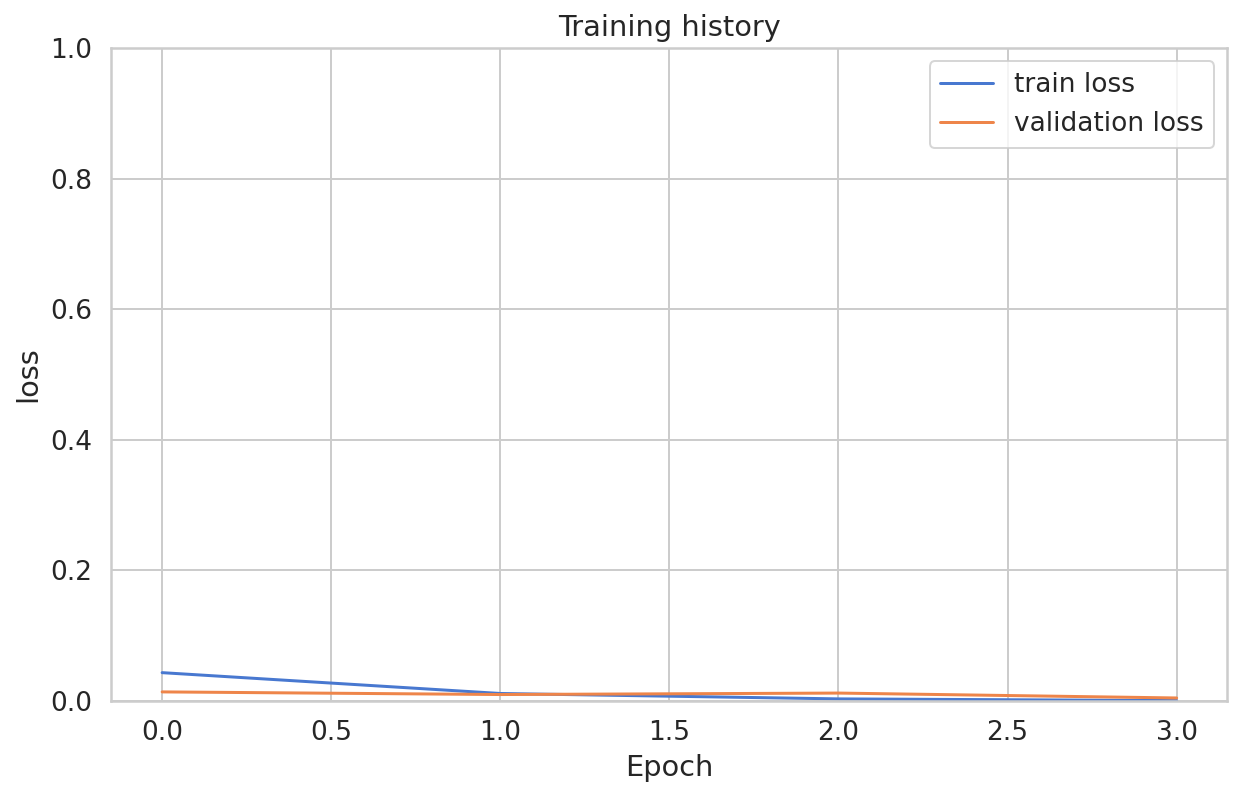

In [29]:
# We can look at the training vs validation losses

plt.plot(history['train_loss'], label='train loss')
plt.plot(history['val_loss'], label='validation loss')

plt.title('Training history')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

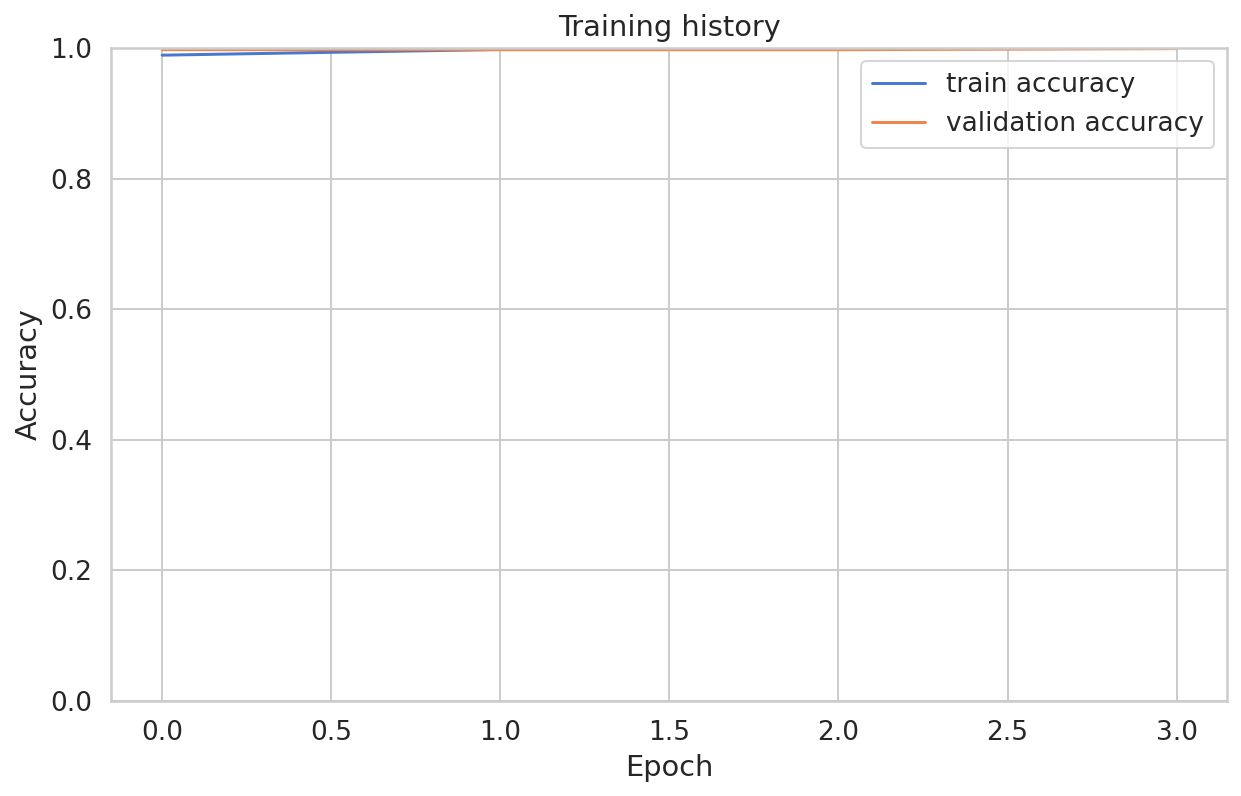

In [30]:
# We can look at the training vs validation accuracy:

plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

The training accuracy starts to approach 100% after 2 epochs or so.

In [31]:
# loading a pretrained model

# model = NewsClassifier(len(CLASS_NAMES))
# model.load_state_dict(torch.load(PRE_TRAINED_MODEL + model_path))
# model = model.to(device)

### Testing and evaluating the model

So how good is our model on predicting sentiment? Let's start by calculating the accuracy on the test data:

In [32]:
test_acc, _ = eval_model(model, test_data_loader, loss_fn, device, len(df_test))

print('Accuracy = ' , test_acc.item() * 100, '%')

Accuracy =  100.0 %


In [33]:
"""
The following is a helper function to get the predictions from our model using 
the test portion of the data.
"""

def get_predictions(model, data_loader):
    model = model.eval()
    
    news_text_strs = []
    predictions = []
    prediction_probs = []
    real_values = []

    with torch.no_grad():
        for d in data_loader:

            texts = d["news_text_str"]
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            labels = d["labels"].to(device)

            outputs = model(
              input_ids=input_ids,
              attention_mask=attention_mask
            )
            _, preds = torch.max(outputs, dim=1)

            probs = F.softmax(outputs, dim=1)

            news_text_strs.extend(texts)
            predictions.extend(preds)
            prediction_probs.extend(probs)
            real_values.extend(labels)

    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()
    
    return news_text_strs, predictions, prediction_probs, real_values

This is similar to the evaluation function, except that we're storing the text of the reviews and the predicted probabilities (by applying the softmax on the model outputs):

In [34]:
y_news_text_strs, y_pred, y_pred_probs, y_test = get_predictions(model, test_data_loader)

Let's have a look at the classification report

In [35]:
print(classification_report(y_test, y_pred, target_names=CLASS_NAMES, digits=4)) 

              precision    recall  f1-score   support

        FAKE     1.0000    1.0000    1.0000       858
        REAL     1.0000    1.0000    1.0000      1022

    accuracy                         1.0000      1880
   macro avg     1.0000    1.0000    1.0000      1880
weighted avg     1.0000    1.0000    1.0000      1880



In [36]:
# Compute the Matthews correlation coefficient (MCC)

from sklearn.metrics import matthews_corrcoef
mcc = matthews_corrcoef(y_test, y_pred)
print('MCC = ', mcc * 100, '%') 

MCC =  100.0 %



We'll continue with the confusion matrix:

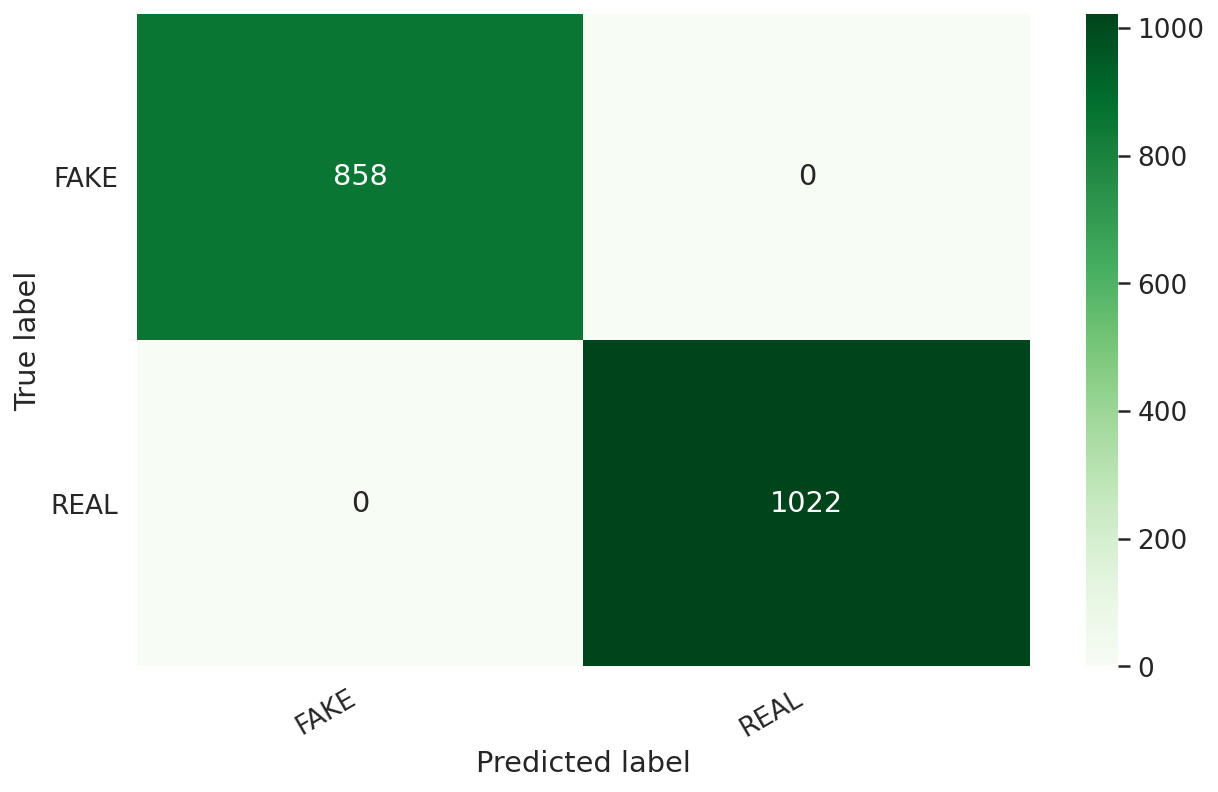

In [37]:
def show_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Greens")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
    plt.xlabel('Predicted label')
    plt.ylabel('True label')

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=CLASS_NAMES, columns=CLASS_NAMES)
show_confusion_matrix(df_cm)


That's a good overview of the performance of our model. But let's have a look at misclassified example from our test data.

In [38]:
for i in range(len(y_test)):
    if y_test[i] != y_pred[i]:
        print(i)

In [39]:
idx = 408

news_text = y_news_text_strs[idx]
true_label = y_test[idx]
pred_df = pd.DataFrame({
    'class_names': CLASS_NAMES,
    'values': y_pred_probs[idx]})

In [40]:
print(pred_df.values)

[['FAKE' 0.9999986886978149]
 ['REAL' 1.3605297226604307e-06]]


In [41]:
print(f'True Label: {le.inverse_transform([true_label])}')
print()
news_text2 = "\n".join(wrap(news_text))#[:500]
# print("\n".join(wrap(news_text)))
print('Text:\n', news_text2)

True Label: ['FAKE']

Text:
 Why did Satan-2 shock the West? 31.10.2016 The recent publication of
images of Russia's new intercontinental ballistic missile " Sarmat "
created quite a stir in Western media. The Daily Mail, for example,
terrified British readers with an article saying that the new Russian
missile would be able to destroy England and Wales at once. The New
York Post called the missile a "devil in disguise" which can easily
reach New York City. The Daily Star published a map of the US East
Coast designating the targets, which the missile could reach. The
article even gives an approximate amount of victims (in millions за
people). However, there were also skeptics. For example, Igor
Sutyagin, a man, who had served nearly eleven years in Russia for
espionage, and currently serves as a senior officer at the British
Royal Institute for Defense Studies, believes that the new Russian
Sarmat missile (Satan-2) is a fake. "The design details are incorrect,
and I doubt that this mis

### Testing on raw text

Use the model to predict the label of some raw text. I think using !!!! may affect the prediction (higher probability of being fake). 

In [42]:
News_text = 'This is REAL news!!!'

We have to use the tokenizer to encode the text:

In [43]:
encoded_text = TOKENIZER.encode_plus(
    News_text,
    add_special_tokens=True,
    max_length=MAX_LEN,
    return_token_type_ids=False,
    padding='max_length',
    truncation=True,
    return_attention_mask=True,
    return_tensors='pt')

Let's get the predictions from our model:

In [44]:
input_ids = encoded_text['input_ids'].to(device)
attention_mask = encoded_text['attention_mask'].to(device)

output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)
probs = F.softmax(output, dim=1)
prediction_probs = torch.detach(probs).cpu()
# print(prediction)
print(f'Predicted Label: {CLASS_NAMES[prediction]}')

pred_df = pd.DataFrame({
    'class_names': CLASS_NAMES,
    'values': prediction_probs[0]})

print(pred_df.values)

Predected Label: FAKE
[['FAKE' 0.99997878074646]
 ['REAL' 2.1194686269154772e-05]]



Lets try the same text without using the !!!!.

In [45]:
# News_text = 'This is real news.'
News_text = 'Trump lost election.'

encoded_text = TOKENIZER.encode_plus(
    News_text,
    add_special_tokens=True,
    max_length=MAX_LEN,
    return_token_type_ids=False,
    padding='max_length',
    truncation=True,
    return_attention_mask=True,
    return_tensors='pt')

input_ids = encoded_text['input_ids'].to(device)
attention_mask = encoded_text['attention_mask'].to(device)

output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)
probs = F.softmax(output, dim=1)
prediction_probs = torch.detach(probs).cpu()
# print(prediction)
print(f'Predicted Label: {CLASS_NAMES[prediction]}')

pred_df = pd.DataFrame({
    'class_names': CLASS_NAMES,
    'values': prediction_probs[0]})

print(pred_df.values)

Predected Label: REAL
[['FAKE' 8.27784515422536e-06]
 ['REAL' 0.999991774559021]]


## References

- [BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding](https://arxiv.org/abs/1810.04805)
- [RoBERTa: A Robustly Optimized BERT Pretraining Approach](https://arxiv.org/abs/1907.11692)
- [The Illustrated BERT, ELMo, and co.](https://jalammar.github.io/illustrated-bert/)
- [Hierarchical Transformers for Long Document Classification](https://arxiv.org/abs/1910.10781)
- [How to Fine-Tune BERT for Text Classification?](https://arxiv.org/pdf/1905.05583.pdf)
- [Sentiment Analysis with BERT and Transformers by Hugging Face using PyTorch and Python](https://curiousily.com/posts/sentiment-analysis-with-bert-and-hugging-face-using-pytorch-and-python/)
- [BERT Fine-Tuning Tutorial with PyTorch](https://mccormickml.com/2019/07/22/BERT-fine-tuning/)

- [Huggingface Transformers](https://huggingface.co/transformers/)
- [BERT Explained: State of the art language model for NLP](https://towardsdatascience.com/bert-explained-state-of-the-art-language-model-for-nlp-f8b21a9b6270)